### Name: Qiaoqiao Zou ###

#----------------------------------Setting 1------------------------------#

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV,train_test_split

In [2]:
# Load the digits dataset
digits = load_digits()
X = digits.data        # Features (1797 samples, 64 features each)
y = digits.target      # Labels (digits 0 through 9)

# Split into training and test sets (e.g., 70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

## Find the best selection and number of feartures ##

In [3]:
top_k = 25

In [4]:
# ---------- Random Forest Feature Selection ----------
def rf_feature_selection(X_train, y_train, k):
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1][:k]
    return indices, importances

rf_indices, rf_importances = rf_feature_selection(X_train, y_train, top_k)
X_train_rf = X_train[:, rf_indices]
X_test_rf = X_test[:, rf_indices]

In [5]:
# ---------- PCA Feature Reduction ----------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=top_k)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

            Classifier  RF Accuracy  PCA Accuracy
0  Logistic Regression     0.940741      0.950000
1              RBF SVM     0.981481      0.977778
2           Linear SVM     0.957407      0.951852


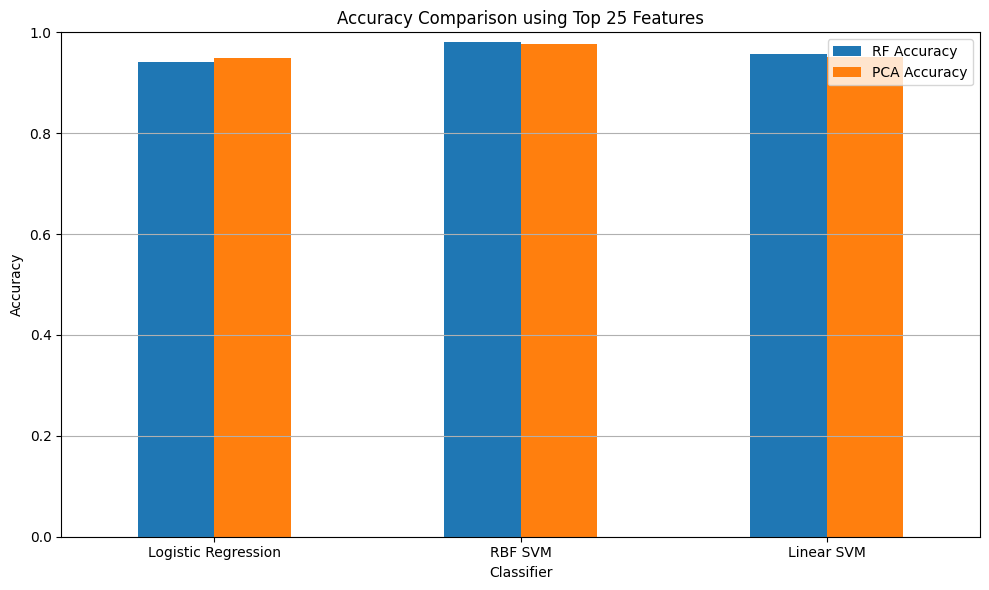

In [6]:
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=2000, random_state=42),
    "RBF SVM": SVC(kernel='rbf', gamma='scale', random_state=42),
    "Linear SVM": SVC(kernel='linear', random_state=42)
}

results = []

for name, clf in classifiers.items():
    # RF-based
    clf.fit(X_train_rf, y_train)
    acc_rf = clf.score(X_test_rf, y_test)

    # PCA-based
    clf.fit(X_train_pca, y_train)
    acc_pca = clf.score(X_test_pca, y_test)

    results.append({
        "Classifier": name,
        "RF Accuracy": acc_rf,
        "PCA Accuracy": acc_pca
    })

# ---------- Display Results ----------
df_results = pd.DataFrame(results)
print(df_results)

# ---------- Plot ----------
df_results.set_index("Classifier")[["RF Accuracy", "PCA Accuracy"]].plot(kind='bar', figsize=(10, 6))
plt.title(f"Accuracy Comparison using Top {top_k} Features")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

So , the least PCA dimension: top_k = 25, Random Forest Feature Selection,
Classifier: SVC(kernel='rbf')
### Parameter adjustment: optimize C and gamma ###

## Find out the parameters of model ##

In [7]:
# Building the pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', SVC(kernel='rbf'))
])

# Setting the parameter grid
param_grid = {
    'clf__C': [0.1, 1, 10, 100],
    'clf__gamma': [0.001, 0.01, 0.1, 1]
}

# GridSearchCV
grid = GridSearchCV(pipe, param_grid, cv=3, verbose=2, n_jobs=-1)
grid.fit(X_train_rf, y_train)

# Test set evaluation
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test_rf)
acc = accuracy_score(y_test, y_pred)

print("Best Parameters:", grid.best_params_)
print(f"Test Accuracy: {acc * 100:.2f}%")

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best Parameters: {'clf__C': 1, 'clf__gamma': 0.1}
Test Accuracy: 98.33%


## Fine-tune the minimum features value ##

In [8]:
topk_range = range(15, 25, 1)  # Integers from 15 to 25 in ascending order to test the number of
for k in topk_range:
    # Select the top k features
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1][:k]
    
    X_train_rf = X_train[:, indices]
    X_test_rf = X_test[:, indices]

    # Training with optimal parameters
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', SVC(kernel='rbf', C=1, gamma=0.1, random_state=42))
    ])
    pipe.fit(X_train_rf, y_train)
    acc = pipe.score(X_test_rf, y_test)

    print(f"top_k = {k} → Test Accuracy = {acc * 100:.2f}%")
    
    if acc >= 0.98:
        print(f"top_k = {k} ")
        break


top_k = 15 → Test Accuracy = 95.56%
top_k = 16 → Test Accuracy = 95.74%
top_k = 17 → Test Accuracy = 95.93%
top_k = 18 → Test Accuracy = 96.30%
top_k = 19 → Test Accuracy = 97.41%
top_k = 20 → Test Accuracy = 97.41%
top_k = 21 → Test Accuracy = 97.59%
top_k = 22 → Test Accuracy = 97.78%
top_k = 23 → Test Accuracy = 98.15%
top_k = 23 


## conclusion ##

So, the minimum number of features is 23, and the selection method is Random Forest Feature;

and the model is RBF SVM;

The parameters are: C=1, gamma=0.1